# Random

In [4]:
# Librairies
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
import polars.selectors as cs
from pathlib import Path


# Values
mu = 180
theta = 90


# Data
root = Path("/home/nicolas/Documents/Workspace/nucleo/outputs/2026-02-26__PC/nucleo__compactionrandom_0")
paths = [str(p) for p in root.rglob("*.parquet")]
df_sorted = (
    pl.scan_parquet(paths)
    .filter(
        (pl.col("landscape") == "random") &
        (pl.col("mu") == mu) &
        (pl.col("theta") == theta)
    )
    .select(cs.numeric() | cs.boolean() | cs.string() | pl.col("results") | pl.col("results_mean"))
    .collect()
    .sort(by=["landscape", "bpmin", "l"],
          descending=[False, False, False]
        )
)
print(df_sorted)


# Getting Values
landscape       = df_sorted["landscape"].to_list()[0]
mu              = df_sorted["mu"].to_numpy()[0]
th              = df_sorted["theta"].to_numpy()[0]
s               = df_sorted["s"].to_numpy()[0]
l               = df_sorted["l"].to_numpy()
l_values        = np.unique(l)
bpmin           = df_sorted["bpmin"].to_numpy()
bpmin_values    = np.unique(bpmin)
Lmin            = df_sorted["Lmin"].to_numpy()[0]
Lmax            = df_sorted["Lmax"].to_numpy()[0]
bps             = df_sorted["bps"].to_numpy()[0]
tmax            = df_sorted["tmax"].to_numpy()[0]
dt              = df_sorted["dt"].to_numpy()[0]

results         = df_sorted["results"].to_numpy()
results_mean    = df_sorted["results_mean"].to_numpy()
v_mean          = df_sorted["v_mean"].to_numpy()
vi_med          = df_sorted["vi_med"].to_numpy()
wf              = df_sorted["wf"].to_numpy()

d               = 1 / (s + l)
v_th            = mu * d * l
ratio           = v_mean / v_th
c               = (150 + l) / (35 + l)
v_mean_bp       = v_mean * c

chromatin       = np.arange(Lmin, Lmax, bps)
time            = np.arange(0, tmax, dt)

shape: (225, 60)
┌───────────┬───────┬──────────┬───────────┬───┬───────┬────────┬───────────┬────────────┐
│ algorithm ┆ fact  ┆ factmode ┆ landscape ┆ … ┆ dt_mp ┆ alpha0 ┆ bound_low ┆ bound_high │
│ ---       ┆ ---   ┆ ---      ┆ ---       ┆   ┆ ---   ┆ ---    ┆ ---       ┆ ---        │
│ str       ┆ bool  ┆ str      ┆ str       ┆   ┆ f64   ┆ i64    ┆ i64       ┆ i64        │
╞═══════════╪═══════╪══════════╪═══════════╪═══╪═══════╪════════╪═══════════╪════════════╡
│ one_step  ┆ false ┆ none     ┆ random    ┆ … ┆ 0.5   ┆ 1      ┆ 5         ┆ 80         │
│ one_step  ┆ false ┆ none     ┆ random    ┆ … ┆ 0.5   ┆ 1      ┆ 5         ┆ 80         │
│ one_step  ┆ false ┆ none     ┆ random    ┆ … ┆ 0.5   ┆ 1      ┆ 5         ┆ 80         │
│ one_step  ┆ false ┆ none     ┆ random    ┆ … ┆ 0.5   ┆ 1      ┆ 5         ┆ 80         │
│ one_step  ┆ false ┆ none     ┆ random    ┆ … ┆ 0.5   ┆ 1      ┆ 5         ┆ 80         │
│ …         ┆ …     ┆ …        ┆ …         ┆ … ┆ …     ┆ …      ┆ …      

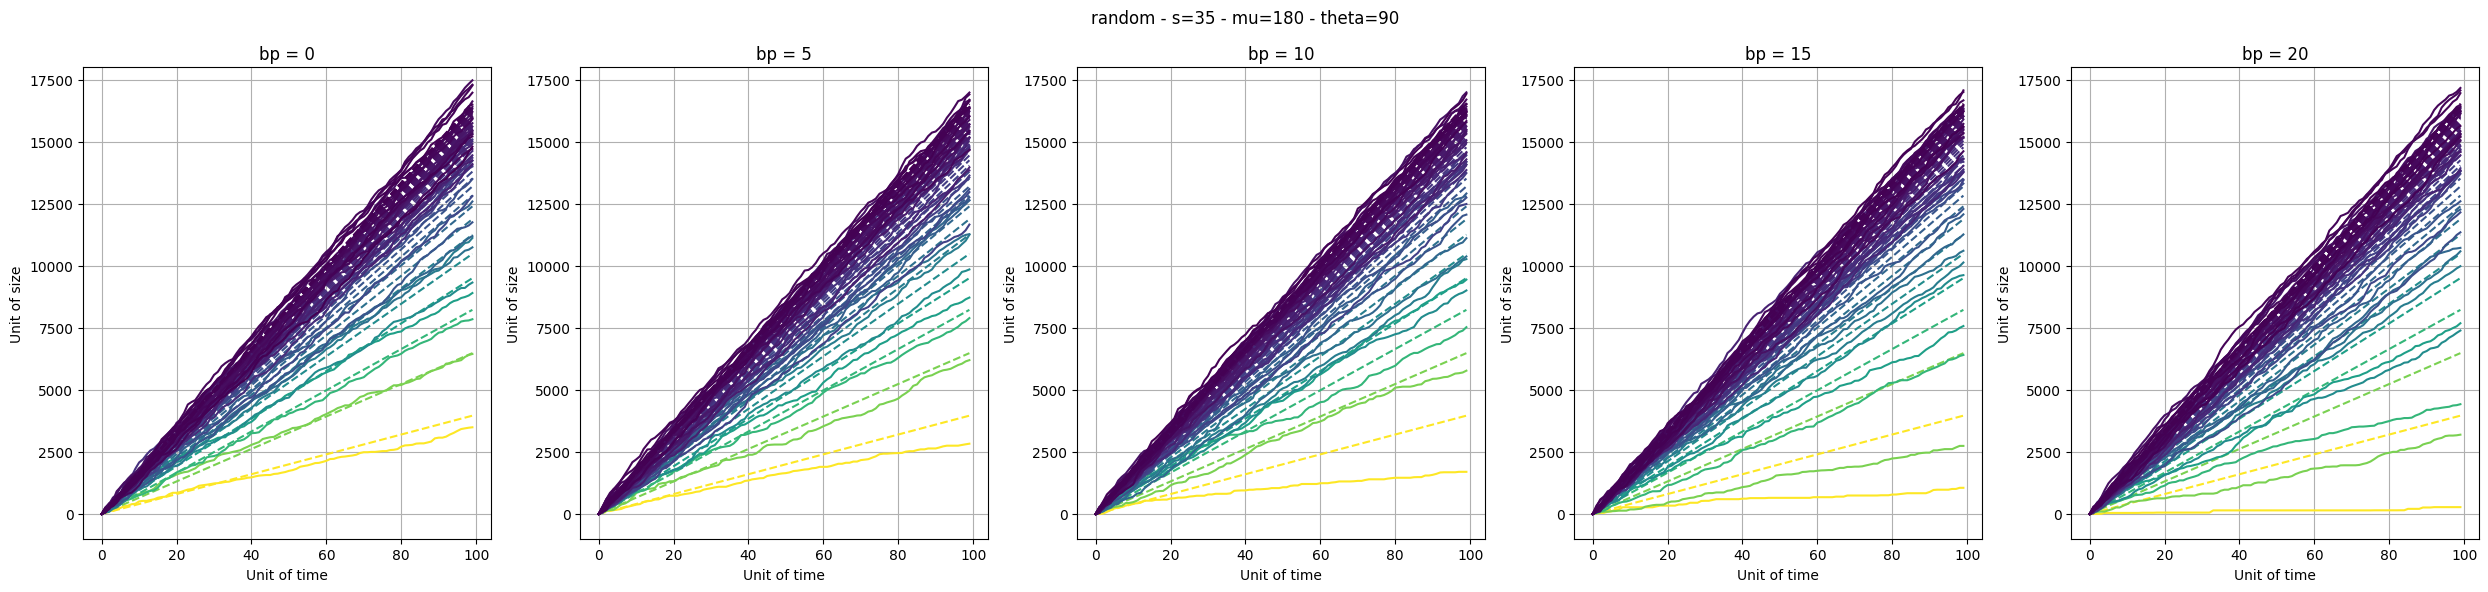

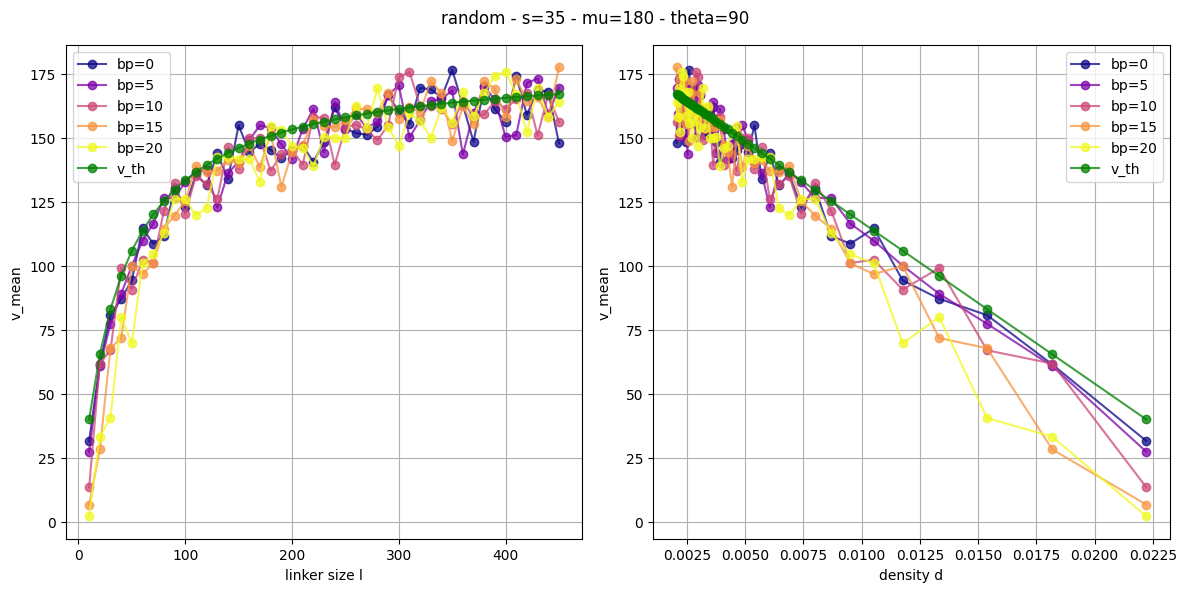

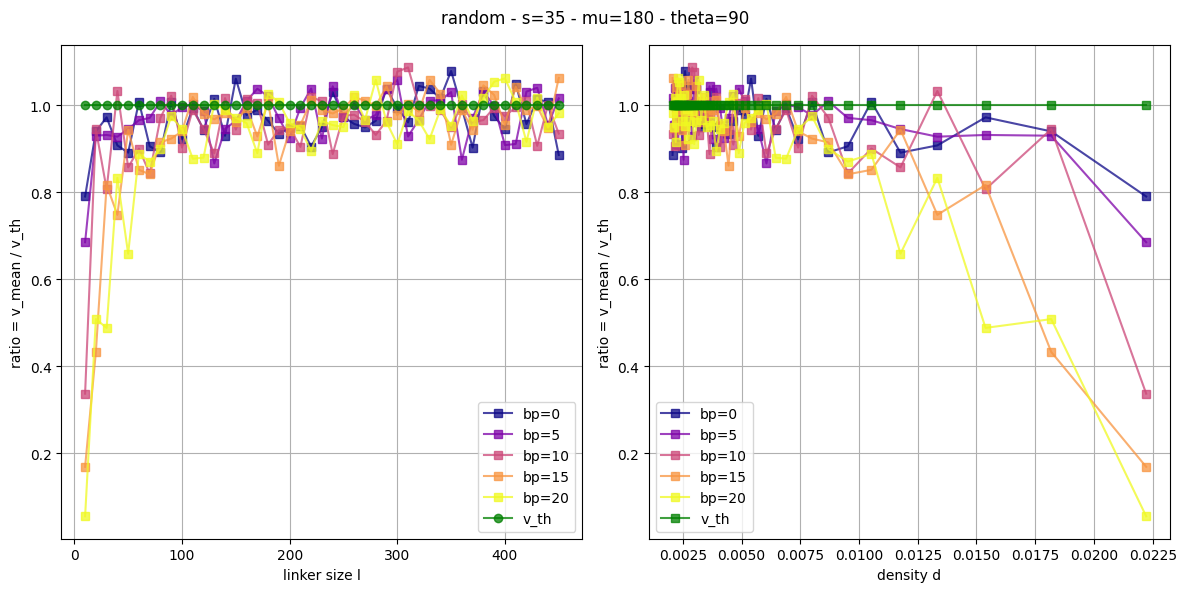

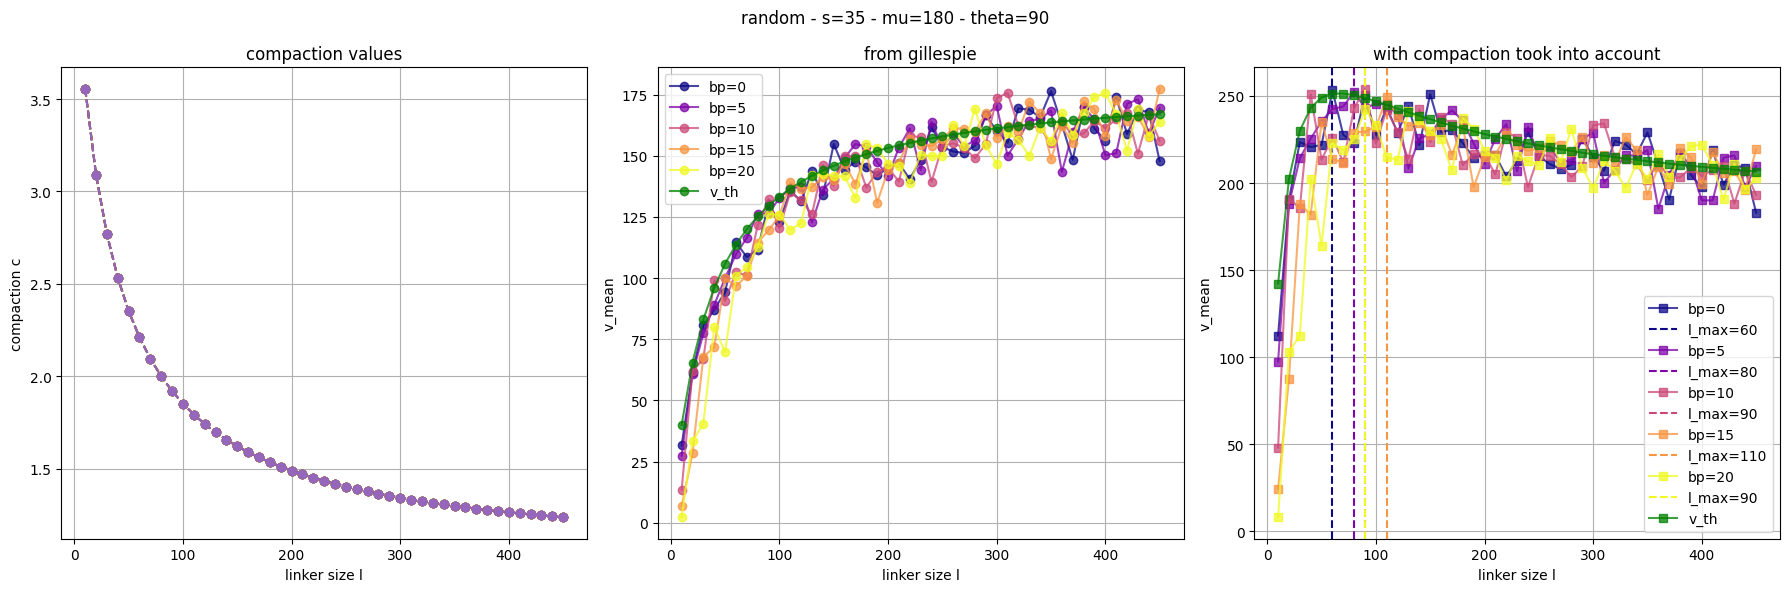

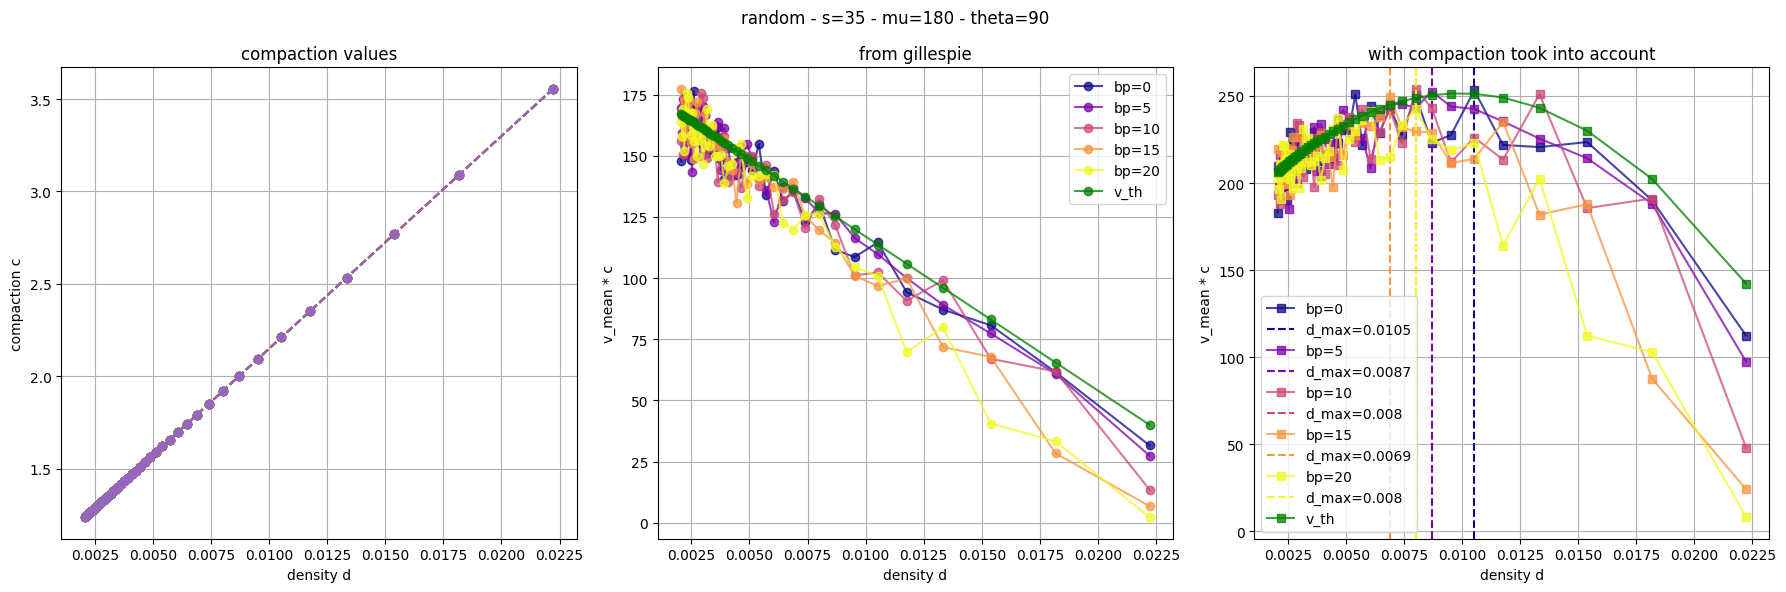

In [9]:
# ─────────────────────────────────────────────
# RANDOM - Trajectories
# ─────────────────────────────────────────────

nc = len(bpmin_values)
fig, axs = plt.subplots(nrows=1, ncols=nc, figsize=(5*nc,6))
plt.suptitle(f"{landscape} - s={s} - mu={mu} - theta={th}")

if nc == 1:
    axs = [axs]

cmap = plt.cm.viridis
norm = plt.Normalize(vmin=min(d), vmax=max(d))

for ax, bp in zip(axs, bpmin_values):
    ax.set_title(f"bp = {bp}")
    results_mean_bp = df_sorted.filter(pl.col("bpmin") == bp)["results_mean"].to_numpy()
    wf_bp = df_sorted.filter(pl.col("bpmin") == bp)["wf"].to_numpy()

    for results, l_val, d_val, v_th_val, wf_val in zip(results_mean_bp, l, d, v_th, wf_bp):
        color = cmap(norm(d_val))
        ax.plot(time, results, label=f"l={l_val} - d={np.round(d_val, 3)} model - wf={wf_val}", ls="-", color=color)
        ax.plot(time, time * v_th_val, label=f"l={l_val} - d={np.round(d_val, 3)} theo - wf={wf_val}", ls="--", color=color)
    ax.set_xlabel("Unit of time")
    ax.set_ylabel("Unit of size")
    ax.set_ylim([-1_000, 18_000])
    ax.grid(True, which="both")
    # ax.loglog(True)
    # ax.legend(title="linkersize - density", ncol=2, fontsize=8)

plt.tight_layout()
plt.show()


# ─────────────────────────────────────────────
# RANDOM - v_mean and vi_med
# ─────────────────────────────────────────────

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
plt.suptitle(f"{landscape} - s={s} - mu={mu} - theta={th}")

cmap = plt.cm.cmap = plt.cm.plasma
norm = plt.Normalize(vmin=min(bpmin_values), vmax=max(bpmin_values))

for bp in bpmin_values:
    color           = cmap(norm(bp))
    df_plot         = df_sorted.filter(pl.col("bpmin") == bp)
    l               = df_plot["l"].to_numpy()
    s               = df_plot["s"].to_numpy()[0]
    d               = 1 / (s + l)
    v_mean          = df_plot["v_mean"]
    v_th            = mu * d * l
    ratio           = v_mean / v_th
    axs[0].plot(l, v_mean, color=color, label=f"bp={bp}", marker="o", alpha=0.75)
    axs[1].plot(d, v_mean, color=color, label=f"bp={bp}", marker="o", alpha=0.75)
    
axs[0].plot(l, v_th, color="g", label="v_th", marker="o", alpha=0.75)
axs[1].plot(d, v_th, color="g", label="v_th", marker="o", alpha=0.75)

axs[0].set_xlabel("linker size l")
axs[0].set_ylabel("v_mean")
axs[0].grid(True, which="both")
axs[0].legend()
# axs[0].loglog(False)

axs[1].set_xlabel("density d")
axs[1].set_ylabel("v_mean")
axs[1].grid(True, which="both")
axs[1].legend()
# axs[1].loglog(False)

plt.tight_layout()
plt.show()


# ─────────────────────────────────────────────
# RANDOM - ratio of v_th and v_model
# ─────────────────────────────────────────────

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
plt.suptitle(f"{landscape} - s={s} - mu={mu} - theta={th}")

cmap = plt.cm.cmap = plt.cm.plasma
norm = plt.Normalize(vmin=min(bpmin_values), vmax=max(bpmin_values))

for bp in bpmin_values:
    color           = cmap(norm(bp))
    df_plot         = df_sorted.filter(pl.col("bpmin") == bp)
    l               = df_plot["l"].to_numpy()
    s               = df_plot["s"].to_numpy()[0]
    d               = 1 / (s + l)
    v_mean          = df_plot["v_mean"]
    v_th            = mu * d * l
    ratio           = v_mean / v_th

    axs[0].plot(l, ratio, color=color, label=f"bp={bp}", marker="s", alpha=0.75)
    axs[1].plot(d, ratio, color=color, label=f"bp={bp}", marker="s", alpha=0.75)
    
axs[0].plot(l, v_th / v_th, color="g", label="v_th", marker="o", alpha=0.75)
axs[1].plot(d, v_th / v_th, color="g", label="v_th", marker="s", alpha=0.75)

axs[0].set_xlabel("linker size l")
axs[0].set_ylabel("ratio = v_mean / v_th")
axs[0].grid(True, which="both")
axs[0].legend()

axs[1].set_xlabel("density d")
axs[1].set_ylabel("ratio = v_mean / v_th")
axs[1].grid(True, which="both")
axs[1].legend()

plt.tight_layout()
plt.show()


# ─────────────────────────────────────────────
# RANDOM - c + v_mean + v_mean_bp + via l
# ─────────────────────────────────────────────

fig, axs = plt.subplots(1, 3, figsize=(18,6))
plt.suptitle(f"{landscape} - s={s} - mu={mu} - theta={th}")
cmap = plt.cm.cmap = plt.cm.plasma
norm = plt.Normalize(vmin=min(bpmin_values), vmax=max(bpmin_values))

for bp in bpmin_values:
    color           = cmap(norm(bp))
    df_plot         = df_sorted.filter(pl.col("bpmin") == bp)
    l               = df_plot["l"].to_numpy()
    s               = df_plot["s"].to_numpy()[0]
    d               = 1 / (s + l)
    v_mean          = df_plot["v_mean"]
    v_th            = mu * d * l
    ratio           = v_mean / v_th
    d               = 1 / (s + l)
    c               = (150 + l) / (35 + l)
    v_mean_bp       = v_mean * c
    axs[0].plot(l, c, "o--")
    # axes[1].plot(l, v_th, "o--", label="theoretical", alpha=0.75)
    axs[1].plot(l, v_mean, color=color, marker="o", label=f"bp={bp}", alpha=0.75)
    # axes[2].plot(l, v_th * c, "s--", label="v_th * c", alpha=0.75)
    axs[2].plot(l, v_mean_bp, color=color, marker="s", label=f"bp={bp}", alpha=0.75)
    axs[2].axvline(l[np.argmax(v_mean_bp)], color=color, ls="--", label=f"l_max={l[np.argmax(v_mean_bp)]}")
    
axs[1].plot(l, v_th, color="g", label="v_th", marker="o", alpha=0.75)
axs[2].plot(l, v_th * c, color="g", label="v_th", marker="s", alpha=0.75)

axs[0].set_xlabel("linker size l")
axs[0].set_ylabel("compaction c")
axs[0].set_title("compaction values")
axs[0].grid(True, which="both")

axs[1].set_xlabel("linker size l")
axs[1].set_ylabel("v_mean")
axs[1].set_title("from gillespie")
axs[1].grid(True, which="both")
axs[1].legend()

axs[2].set_xlabel("linker size l")
axs[2].set_ylabel("v_mean")
axs[2].set_title("with compaction took into account")
axs[2].grid(True, which="both")
# axs[2].loglog(True)
axs[2].legend()

plt.tight_layout()
plt.show()


# ─────────────────────────────────────────────
# RANDOM - c + v_mean + v_mean_bp + via d
# ─────────────────────────────────────────────

fig, axs = plt.subplots(1, 3, figsize=(18,6))
plt.suptitle(f"{landscape} - s={s} - mu={mu} - theta={th}")
cmap = plt.cm.cmap = plt.cm.plasma
norm = plt.Normalize(vmin=min(bpmin_values), vmax=max(bpmin_values))

for bp in bpmin_values:
    color           = cmap(norm(bp))
    df_plot         = df_sorted.filter(pl.col("bpmin") == bp)
    l               = df_plot["l"].to_numpy()
    s               = df_plot["s"].to_numpy()[0]
    d               = 1 / (s + l)
    v_mean          = df_plot["v_mean"]
    v_th            = mu * d * l
    ratio           = v_mean / v_th
    d               = 1 / (s + l)
    c               = (150 + l) / (35 + l)
    v_mean_bp       = v_mean * c
    axs[0].plot(d, c, "o--")
    # axes[1].plot(l, v_th, "o--", label="theoretical", alpha=0.75)
    axs[1].plot(d, v_mean, color=color, marker="o", label=f"bp={bp}", alpha=0.75)
    # axes[2].plot(l, v_th * c, "s--", label="v_th * c", alpha=0.75)
    axs[2].plot(d, v_mean_bp, color=color, marker="s", label=f"bp={bp}", alpha=0.75)
    axs[2].axvline(d[np.argmax(v_mean_bp)], color=color, ls="--", label=f"d_max={np.round(d[np.argmax(v_mean_bp)],4)}")

axs[1].plot(d, v_th, color="g", label="v_th", marker="o", alpha=0.75)
axs[2].plot(d, v_th * c, color="g", label="v_th", marker="s", alpha=0.75)

axs[0].set_xlabel("density d")
axs[0].set_ylabel("compaction c")
axs[0].set_title("compaction values")
axs[0].grid(True, which="both")

axs[1].set_xlabel("density d")
axs[1].set_ylabel("v_mean * c")
axs[1].set_title("from gillespie")
axs[1].grid(True, which="both")
axs[1].legend()

axs[2].set_xlabel("density d")
axs[2].set_ylabel("v_mean * c")
axs[2].set_title("with compaction took into account")
axs[2].grid(True, which="both")
# axs[2].loglog(True)
axs[2].legend()

plt.tight_layout()
plt.show()

# PERIODIC

shape: (220, 61)
┌───────────┬───────┬──────────┬───────────┬───┬───────┬────────┬───────────┬────────────┐
│ algorithm ┆ fact  ┆ factmode ┆ landscape ┆ … ┆ dt_mp ┆ alpha0 ┆ bound_low ┆ bound_high │
│ ---       ┆ ---   ┆ ---      ┆ ---       ┆   ┆ ---   ┆ ---    ┆ ---       ┆ ---        │
│ str       ┆ bool  ┆ str      ┆ str       ┆   ┆ f64   ┆ i64    ┆ i64       ┆ i64        │
╞═══════════╪═══════╪══════════╪═══════════╪═══╪═══════╪════════╪═══════════╪════════════╡
│ one_step  ┆ false ┆ none     ┆ periodic  ┆ … ┆ 0.5   ┆ 1      ┆ 5         ┆ 80         │
│ one_step  ┆ false ┆ none     ┆ periodic  ┆ … ┆ 0.5   ┆ 1      ┆ 5         ┆ 80         │
│ one_step  ┆ false ┆ none     ┆ periodic  ┆ … ┆ 0.5   ┆ 1      ┆ 5         ┆ 80         │
│ one_step  ┆ false ┆ none     ┆ periodic  ┆ … ┆ 0.5   ┆ 1      ┆ 5         ┆ 80         │
│ one_step  ┆ false ┆ none     ┆ periodic  ┆ … ┆ 0.5   ┆ 1      ┆ 5         ┆ 80         │
│ …         ┆ …     ┆ …        ┆ …         ┆ … ┆ …     ┆ …      ┆ …      

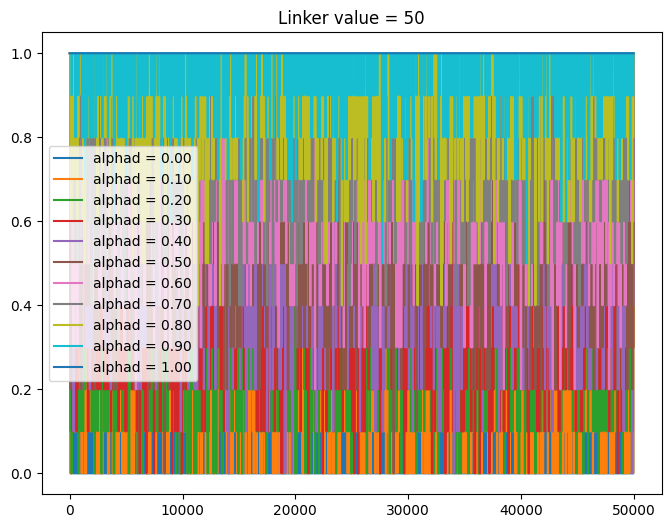

In [10]:
# Librairies
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
import polars.selectors as cs
from pathlib import Path


# Values
mu = 180
theta = 90


# Data
root = Path("/home/nicolas/Documents/Workspace/nucleo/outputs/2026-02-26__PC/nucleo__compactionperiodic_0")
paths = [str(p) for p in root.rglob("*.parquet")]
df_sorted = (
    pl.scan_parquet(paths)
    .filter(
        (pl.col("landscape") == "periodic") &
        (pl.col("mu") == mu) &
        (pl.col("theta") == theta)
    )
    .select(cs.numeric() | cs.boolean() | cs.string() | pl.col("results") | pl.col("results_mean")| pl.col("alpha_mean_a"))
    .collect()
    .sort(by=["landscape", "bpmin", "l", "alphad"],
          descending=[False, False, False, False]
        )
)
print(df_sorted)


# Getting Values
s        = df_sorted["s"].to_numpy()
s_values = np.unique(s)
l        = df_sorted["l"].to_numpy()
l_values = np.unique(l)
alphad   = df_sorted["alphad"].to_numpy()
alphads  = np.unique(alphad)


# Checking proper destruction of obstacles
plt.figure(figsize=(8,6))

l_value = 50
df_sub = df_sorted.filter(pl.col("l") == l_value)

for row in df_sub.iter_rows(named=True):
    alpha_mean_a    = row["alpha_mean_a"]
    alphad          = row["alphad"]
    alpha_value     = np.mean(alpha_mean_a)
    
    plt.plot(alpha_mean_a, alpha=1, label=f"alphad = {alphad:.2f}")
    print(f"alphad = {alphad:.2f} - alpha_value = {alpha_value:.2f} - {alpha_mean_a[0:100]}")

plt.title(f"Linker value = {l_value}")
plt.legend()
plt.show()

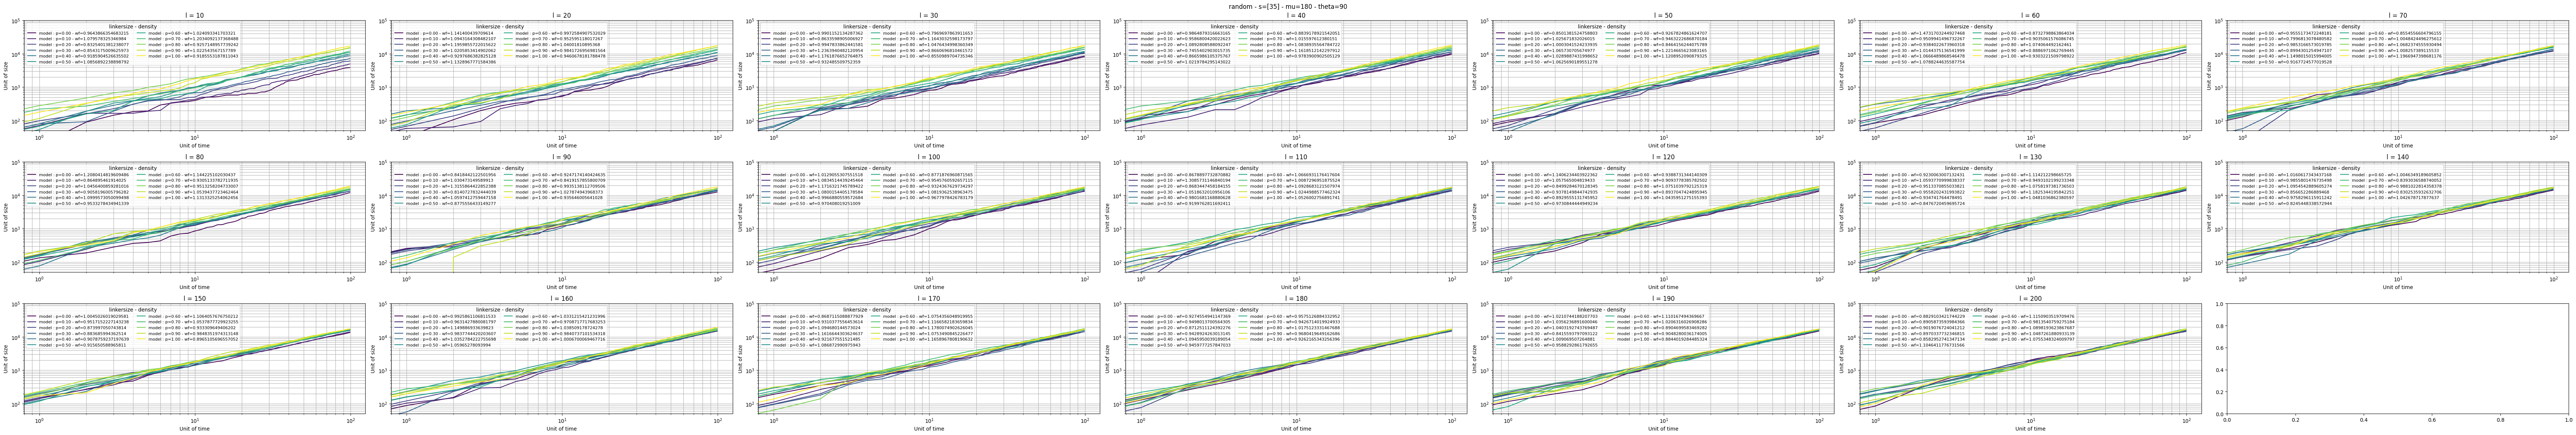

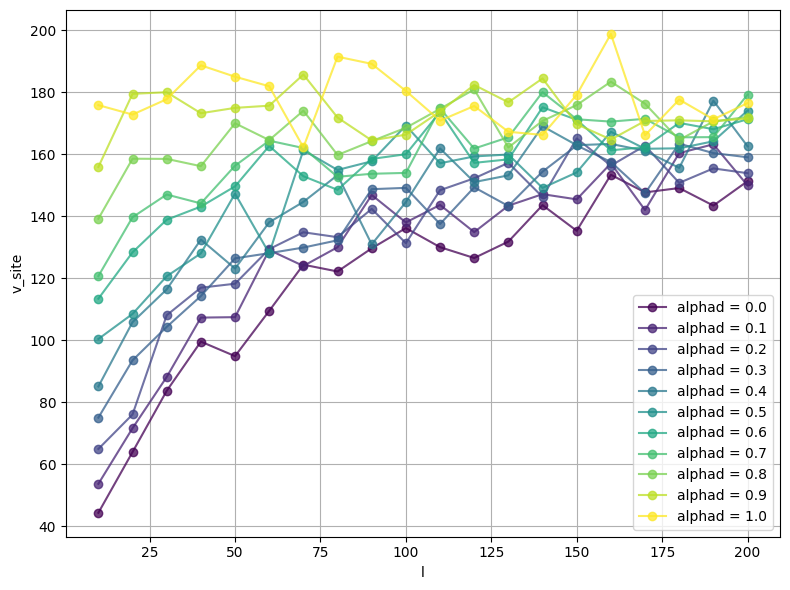

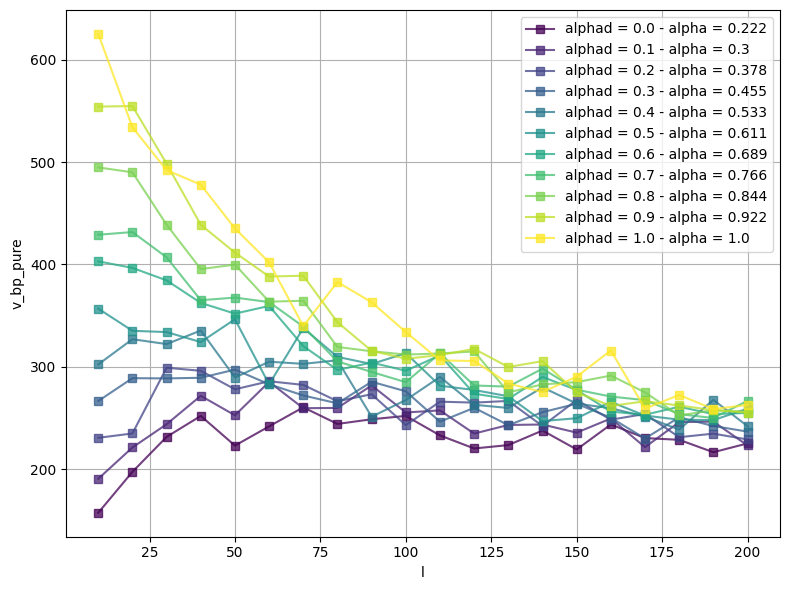

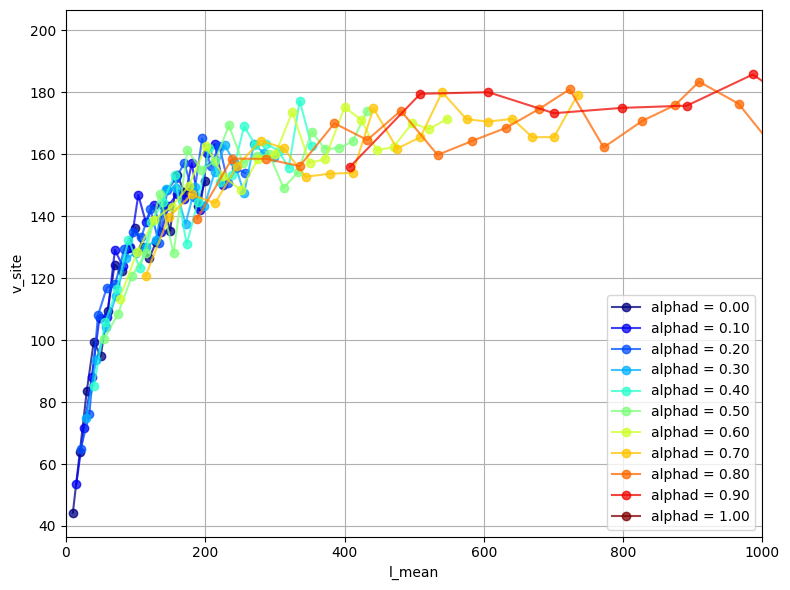

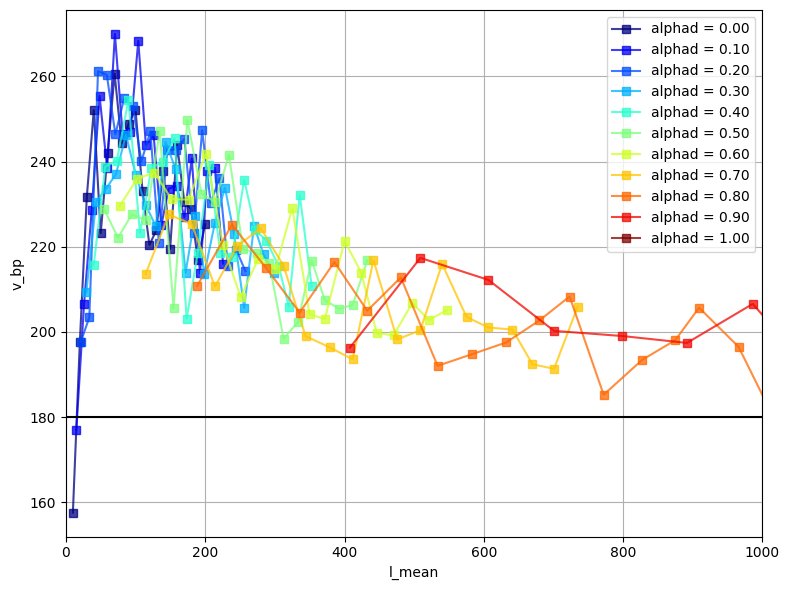

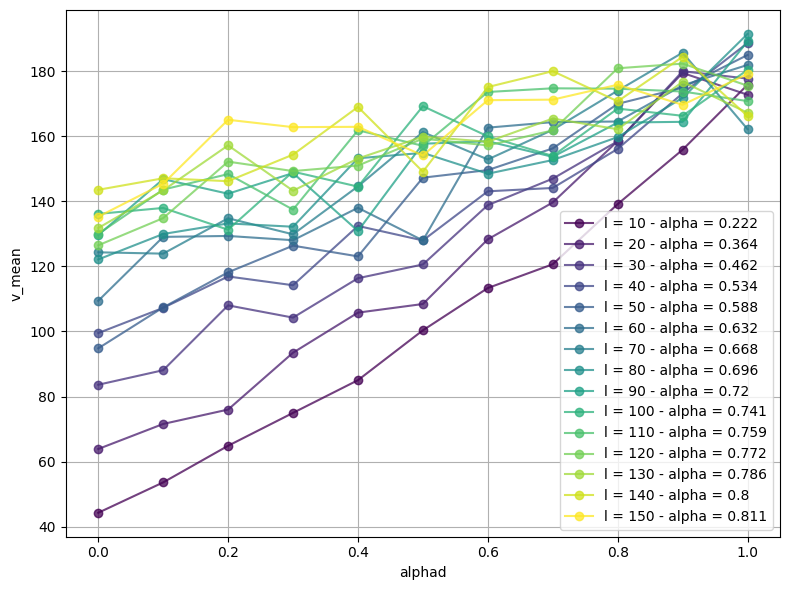

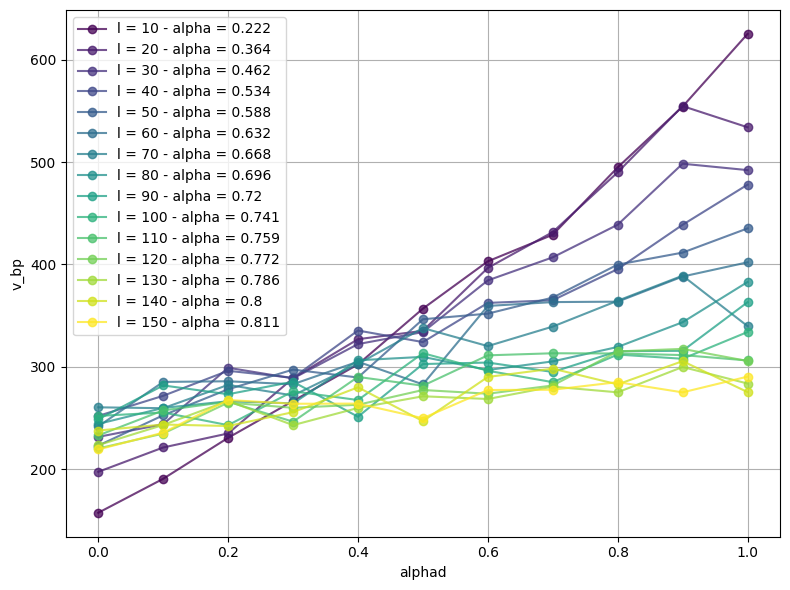

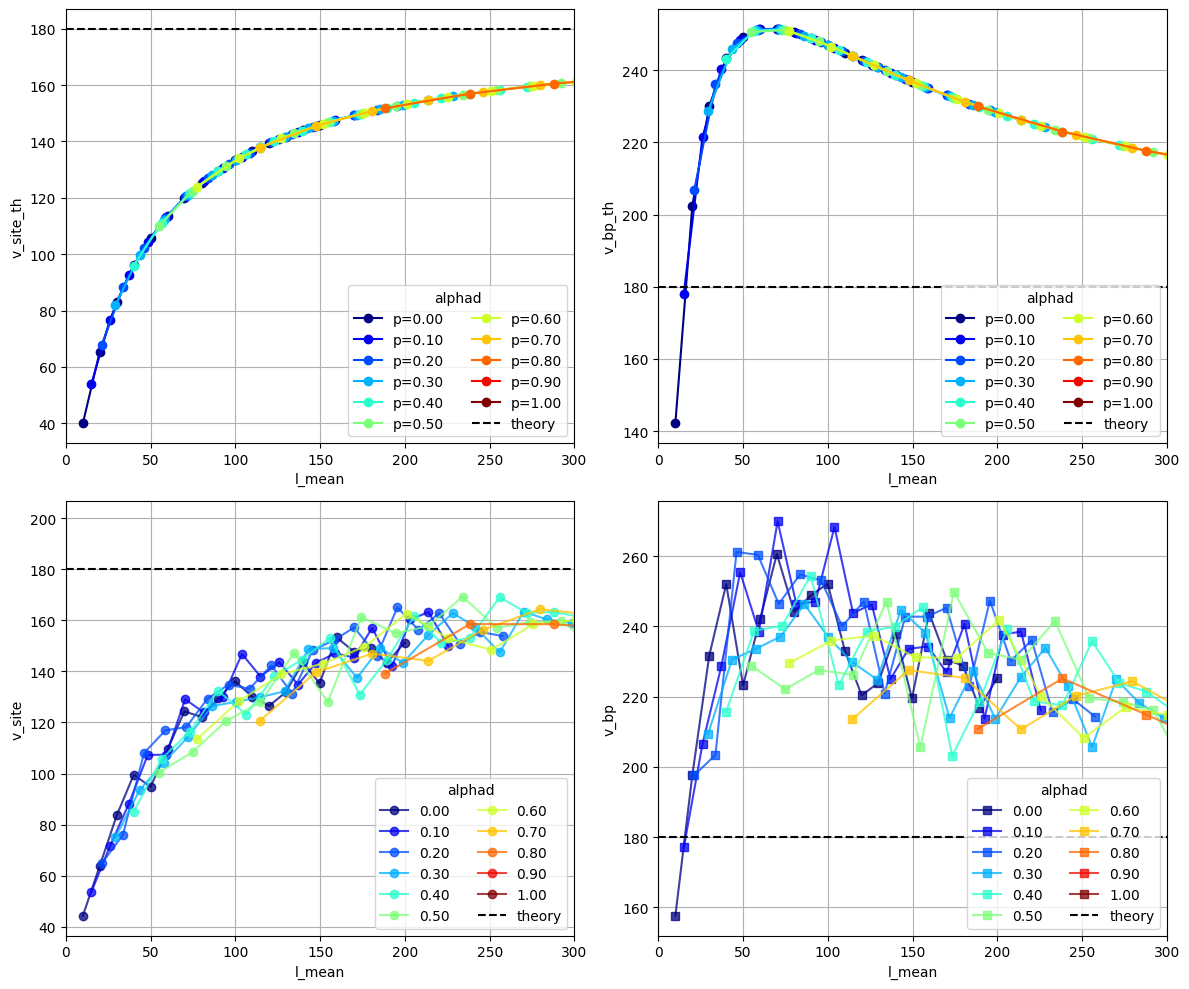

In [11]:
# ─────────────────────────────────────────────
# PERIODIC - Trajectories
# ─────────────────────────────────────────────

nr = 3
nc = int(np.ceil(len(l_values) / nr))
fig, axs = plt.subplots(nrows=nr, ncols=nc, figsize=(10*nc, 12))
plt.suptitle(f"{landscape} - s={s_values} - mu={mu} - theta={th}")
axs = np.array(axs).reshape(-1)

cmap = plt.cm.viridis
norm = plt.Normalize(vmin=min(alphads), vmax=max(alphads))

for ax, l_val in zip(axs, l_values):
    # Filtrage des données pour ce l
    df_l = df_sorted.filter(pl.col("l") == l_val)
    results_mean_l = df_l["results_mean"].to_numpy()
    wf_l = df_l["wf"].to_numpy()
    v_mean_th = df_l["v_mean_th"].to_numpy()

    for results, ad_val, v_th_val, wf_val in zip(results_mean_l, alphads, v_mean_th, wf_l):
        color = cmap(norm(ad_val))

        # courbe modèle
        ax.plot(
            time, results,
            label=f"model : p={ad_val:.2f} - wf={wf_val}",
            ls="-", color=color
        )

        # # courbe théorie
        # ax.plot(
        #     time, time * v_th_val,
        #     label=f" theo : p={p_val:.2f} - wf={wf_val}",
        #     ls="--", color=color
        # )
        
    ax.set_ylim([5e1, 1e5])
    ax.set_title(f"l = {l_val}")
    ax.set_xlabel("Unit of time")
    ax.set_ylabel("Unit of size")
    ax.grid(True, which="both")

    # correction de ax.loglog()
    ax.set_xscale("log")
    ax.set_yscale("log")

    ax.legend(title="linkersize - density", ncol=2, fontsize=8)

plt.tight_layout()
plt.show()


# ─────────────────────────────────────────────
# PERIODIC - Speed in function of linkers : l
# ─────────────────────────────────────────────

# Colors
cmap = plt.cm.viridis
values = sorted(df_sorted["alphad"].unique().to_numpy())
norm = plt.Normalize(min(values), max(values))


# Sites
plt.figure(figsize=(8,6))

for group in df_sorted.partition_by("alphad", as_dict=False):
    
    alphad      = group["alphad"][0]
    l           = group["l"].to_numpy()
    mu          = group["mu"][0]
    v_site      = group["v_mean"].to_numpy()
    alpha_mean_a  = group["alpha_mean_a"].to_numpy()[0]
    color       = cmap(norm(alphad))
    
    plt.plot(l, v_site, c=color, marker="o", ls="-", alpha=0.75,
             label=f"alphad = {np.round(alphad, 3)}"
    )
    
    v_th        = mu * alpha_value

    # plt.plot(l, v_th, c=color, marker="s", ls="--", alpha=0.75,
    #          label=f"alpha = {np.round(alpha_value, 3)}"
    # )
    
plt.xlabel("l")
plt.ylabel("v_site")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Base pairs
plt.figure(figsize=(8,6))

for group in df_sorted.partition_by("alphad", as_dict=False):
    alphad          = group["alphad"][0]
    s               = group["s"].to_numpy()
    l               = group["l"].to_numpy()
    v_site          = group["v_mean"].to_numpy()
    alpha_mean_a  = group["alpha_mean_a"].to_numpy()[0]
    c           = (150 + l) / (35 + l)
    v_bp_pure   = v_site * c
    alpha_value = np.mean(alpha_mean_a)
    color       = cmap(norm(alphad))
    
    plt.plot(l, v_bp_pure, c=color, marker="s", 
             label=f"alphad = {np.round(alphad, 3)} - alpha = {np.round(alpha_value, 3)}", 
             alpha=0.75
    )

plt.xlabel("l")
plt.ylabel("v_bp_pure")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# ─────────────────────────────────────────────
# PERIODIC - Speed in function of linkers : l_mean
# ─────────────────────────────────────────────

# Colors
cmap = plt.cm.jet
values = sorted(df_sorted["alphad"].unique().to_numpy())
norm = plt.Normalize(min(values), max(values))


# Sites
plt.figure(figsize=(8,6))

for group in df_sorted.partition_by("alphad", as_dict=False):
    
    alphad          = group["alphad"][0]
    l_mean          = group["l_mean"].to_numpy()
    v_site          = group["v_mean"].to_numpy()
    color           = cmap(norm(alphad))
    
    plt.plot(l_mean, v_site, c=color, marker="o", ls="-", alpha=0.75,
             label=f"alphad = {alphad:.2f}"
    )

plt.xlim([0,1_000])
plt.xlabel("l_mean")
plt.ylabel("v_site")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Base pairs
plt.figure(figsize=(8,6))

for group in df_sorted.partition_by("alphad", as_dict=False):
    
    alphad          = group["alphad"][0]
    l_mean          = group["l_mean"].to_numpy()
    v_site          = group["v_mean"].to_numpy()
    color           = cmap(norm(alphad))
     
    c               = (150 + l_mean) / (35 + l_mean)
    v_bp            = v_site * c
    
    plt.plot(l_mean, v_bp, c=color, marker="s", ls="-", alpha=0.75,
             label=f"alphad = {alphad:.2f}"
    )

plt.axhline(y=180, c="k")
plt.xlim([0,1_000])
plt.xlabel("l_mean")
plt.ylabel("v_bp")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# ─────────────────────────────────────────────
# PERIODIC - Speed in function of alphad : p
# ─────────────────────────────────────────────

# Values of l
df_subset = df_sorted.filter((pl.col("l") >= 5) & (pl.col("l") <= 150))

# Colors
cmap = plt.cm.viridis
values = sorted(df_subset["l"].unique().to_numpy())
norm = plt.Normalize(min(values), max(values))


# Sites
plt.figure(figsize=(8, 6))

for group in df_subset.partition_by("l", as_dict=False):
    l               = group["l"][0]
    alphad          = group["alphad"].to_numpy()
    v_site          = group["v_mean"].to_numpy()
    alpha_mean_a    = group["alpha_mean_a"].to_numpy()[0]
    alpha_value     = np.mean(alpha_mean_a[10_000 : 20_000])
    color           = cmap(norm(l))
    
    # plt.plot(alphad, v_site, c=color, marker="o", 
    #          label=f"l = {np.round(l, 3)}"
    #          , alpha=0.75
    # )
    
    plt.plot(alphad, v_site, c=color, marker="o", 
            label=f"l = {np.round(l, 3)} - alpha = {np.round(alpha_value, 3)}"
            , alpha=0.75
    )

plt.xlabel("alphad")
plt.ylabel("v_mean")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Base pairs
plt.figure(figsize=(8,6))

for group in df_subset.partition_by("l", as_dict=False):
    l               = group["l"][0]
    alphad          = group["alphad"].to_numpy()
    v_site          = group["v_mean"].to_numpy()
    alpha_mean_a    = group["alpha_mean_a"].to_numpy()[0]
    alpha_value     = np.mean(alpha_mean_a[10_000 : 20_000])
    c               = (150 + l) / (35 + l)
    v_bp            = v_site * c  
    color           = cmap(norm(l))
    
    plt.plot(alphad, v_bp, c=color, marker="o", 
            label=f"l = {np.round(l, 3)} - alpha = {np.round(alpha_value, 3)}"
            , alpha=0.75
    )

plt.xlabel("alphad")
plt.ylabel("v_bp")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# ─────────────────────────────────────────────
# PERIODIC - Main results
# ─────────────────────────────────────────────

# --- Préparation couleurs ---
cmap = plt.cm.jet
values = sorted(df_sorted["alphad"].unique().to_numpy())
norm = plt.Normalize(min(values), max(values))

# --- Début figure ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
(ax1, ax2), (ax3, ax4) = axes
xmax= 300

# 1. v_th_eff vs l_mean
for group in df_subset.partition_by("alphad", as_dict=False):
    l_mean      = group["l_mean"]
    v_mean_th_eff    = group["v_mean_th_eff"]
    alphad      = group["alphad"][0]
    color       = cmap(norm(alphad))
    ax1.plot(l_mean, v_mean_th_eff, c=color, label=f"p={alphad:.2f}", marker="o")

ax1.axhline(y=180, c="k", ls="--", label="theory")
ax1.set_xlim([0,xmax])
ax1.set_xlabel("l_mean")
ax1.set_ylabel("v_site_th")
ax1.legend(title="alphad", ncols=2)
ax1.grid(True)

# 2. v_th = v_th_eff * c
for group in df_subset.partition_by("alphad", as_dict=False):
    l_mean      = group["l_mean"]
    v_mean_th_eff    = group["v_mean_th_eff"]
    alphad      = group["alphad"][0]
    c           = (150 + l_mean) / (35 + l_mean)
    v_th        = v_mean_th_eff * c
    color       = cmap(norm(alphad))
    ax2.plot(l_mean, v_th, c=color, label=f"p={alphad:.2f}", marker="o")

ax2.axhline(y=180, c="k", ls="--", label="theory")
ax2.set_xlim([0,xmax])
ax2.set_xlabel("l_mean")
ax2.set_ylabel("v_bp_th")
ax2.legend(title="alphad", ncols=2)
ax2.grid(True)

# 3. v_site vs l_mean (couleurs par paramètre)
for group in df_sorted.partition_by("alphad", as_dict=False):
    alphad          = group["alphad"][0]
    l_mean          = group["l_mean"].to_numpy()
    v_site          = group["v_mean"].to_numpy()
    color           = cmap(norm(alphad))
    
    ax3.plot(l_mean, v_site, c=color, marker="o", ls="-", alpha=0.75,
             label=f"{alphad:.2f}")

ax3.axhline(y=180, c="k", ls="--", label="theory")
ax3.set_xlim([0,xmax])
ax3.set_xlabel("l_mean")
ax3.set_ylabel("v_site")
ax3.grid(True)
ax3.legend(title="alphad", ncols=2)

# 4. v_bp (base pairs) = v_site * c
for group in df_sorted.partition_by("alphad", as_dict=False):
    alphad          = group["alphad"][0]
    l_mean          = group["l_mean"].to_numpy()
    v_site          = group["v_mean"].to_numpy()
    color           = cmap(norm(alphad))

    c               = (150 + l_mean) / (35 + l_mean)
    v_bp            = v_site * c
    
    ax4.plot(l_mean, v_bp, c=color, marker="s", ls="-", alpha=0.75,
             label=f"{alphad:.2f}")

ax4.axhline(y=180, c="k", ls="--", label="theory")
ax4.set_xlim([0,xmax])
ax4.set_xlabel("l_mean")
ax4.set_ylabel("v_bp")
ax4.grid(True)
ax4.legend(title="alphad", ncols=2)

plt.tight_layout()
plt.show()

/tmp/ipykernel_23027/3869634833.py:19: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  name for name, dtype in lf.schema.items()


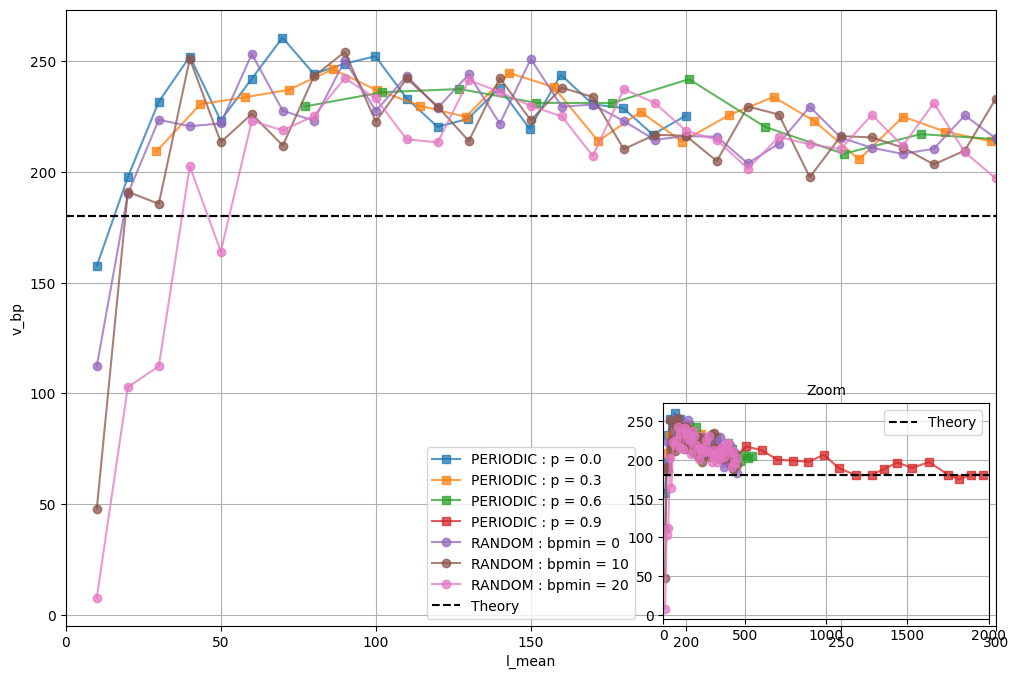

In [12]:
# ─────────────────────────────────────────────
# FIGURE - DENSITY
# ─────────────────────────────────────────────


# 3.1 : Librairies
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from pathlib import Path


# 3.2 : Datas

def load_scalar_columns(paths):
    lf = pl.scan_parquet(paths)

    scalar_cols = [
        name for name, dtype in lf.schema.items()
        if isinstance(dtype, (
            pl.Int8, pl.Int16, pl.Int32, pl.Int64,
            pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64,
            pl.Float32, pl.Float64,
            pl.Boolean,
            pl.Utf8
        ))
    ]

    return lf.select(scalar_cols).collect()


s_w = 35
mu_w, theta_w = 180, 90

# DataFrame : RANDOM
root = Path("/home/nicolas/Documents/Workspace/nucleo/outputs/2026-02-26__PC/nucleo__compactionrandom_0")
paths = [str(p) for p in root.glob("*/**/*.parquet")] or [str(p) for p in root.glob("*/*.parquet")]

df_random = (
    load_scalar_columns(paths)
    .sort(
        by=["landscape", "bpmin", "l", "alphad"],
        descending=[False, False, False, False]
    )
    .filter(
        (pl.col("s") == s_w) &
        (pl.col("mu") == mu_w) &
        (pl.col("theta") == theta_w)
    )
)

# DataFrame : PERIODIC
root = Path("/home/nicolas/Documents/Workspace/nucleo/outputs/2026-02-26__PC/nucleo__compactionperiodic_0")
paths = [str(p) for p in root.glob("*/**/*.parquet")] or [str(p) for p in root.glob("*/*.parquet")]

df_periodic = (
    load_scalar_columns(paths)
    .sort(
        by=["landscape", "bpmin", "l", "alphad"],
        descending=[False, False, False, False]
    )
    .filter(
        (pl.col("s") == s_w) &
        (pl.col("mu") == mu_w) &
        (pl.col("theta") == theta_w)
    )
)


# 3.3 : Plot


# --- Initialization --- #

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.figure(figsize=(12,8))

# Xlmis for plot and inset
xlim_main   = 300
xlim_sub    = 2_000


# --- Periodic --- #

# Periodic : Values to keep
# params_to_keep = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
params_to_keep = [0.0, 0.3, 0.6, 0.9]
df_periodic = df_periodic.with_columns(
    pl.col("alphad").round(3).alias("alphad")
)
df_periodic_filtered = df_periodic.filter(
    pl.col("alphad").is_in(params_to_keep)
)

# Periodic : Colors
random_cmap = plt.cm.viridis
p = df_periodic_filtered["alphad"].to_numpy()
p_values = np.unique(p)
random_norm = plt.Normalize(vmin=min(p_values), vmax=max(p_values))

# Periodic : Loop over configurations
for group in df_periodic_filtered.partition_by("alphad", as_dict=False):
    alphad      = group["alphad"][0]
    l_mean      = group["l_mean"].to_numpy()
    v_site      = group["v_mean"].to_numpy()
    c           = (150 + l_mean) / (35 + l_mean)
    v_bp        = v_site * c
    # color       = random_cmap(random_norm(alphad))    
    plt.plot(l_mean, v_bp, marker="s", ls="-", alpha=0.75, label=f"PERIODIC : p = {alphad}")


# --- Random --- #

# Random : Values to keep
# bpmin_to_keep = [0, 5, 10, 15]
bpmin_to_keep = [0, 10, 20]
df_random = df_random.with_columns(
    pl.col("bpmin").round(3).alias("bpmin")
)
df_random_filtered = df_random.filter(
    pl.col("bpmin").is_in(bpmin_to_keep)
) 

# Random : Colors
random_cmap = plt.cm.plasma
bp = df_random_filtered["bpmin"].to_numpy()
bp_values = np.unique(bp)
random_norm = plt.Normalize(vmin=min(bp_values), vmax=max(bp_values))

# Random : Loop over configurations
for group in df_random_filtered.partition_by("bpmin", as_dict=False):
    bpmin   = group["bpmin"][0]
    l_mean  = group["l"].to_numpy()
    v_site  = group["v_mean"].to_numpy()
    c       = (150 + l_mean) / (35 + l_mean)
    v_bp    = v_site * c
    # color   = random_cmap(random_norm(bpmin))    
    plt.plot(l_mean, v_bp, marker="o", ls="-", alpha=0.75, label=f"RANDOM : bpmin = {bpmin}")


# --- Architecture Plot --- #
plt.axhline(180, c="k", ls="--", label="Theory")
plt.xlim([0, xlim_main])
plt.xlabel("l_mean")
plt.ylabel("v_bp")
plt.grid(True)
plt.axhline(180, c="k", ls="--")
plt.legend(loc="lower center")


# --- Inset --- #

ax = plt.gca()  
ax_inset = inset_axes(ax, width="35%", height="35%", loc="lower right")

# Periodic inset
for group in df_periodic_filtered.partition_by("alphad", as_dict=False):
    alphad      = group["alphad"][0]
    l_mean      = group["l_mean"].to_numpy()
    v_site      = group["v_mean"].to_numpy()
    c           = (150 + l_mean) / (35 + l_mean)
    v_bp        = v_site * c
    # color       = random_cmap(random_norm(alphad))
    ax_inset.plot(l_mean, v_bp, marker="s", ls="-", alpha=0.75)

# Random inset
for group in df_random_filtered.partition_by("bpmin", as_dict=False):
    bpmin   = group["bpmin"][0]
    l_mean  = group["l"].to_numpy()
    v_site  = group["v_mean"].to_numpy()
    c       = (150 + l_mean) / (35 + l_mean)
    v_bp    = v_site * c
    # color   = random_cmap(random_norm(bpmin))
    ax_inset.plot(l_mean, v_bp, marker="o", ls="-", alpha=0.75)

# Inset config
ax_inset.set_xlim([0, xlim_sub])
ax_inset.set_ylim(ax.get_ylim())
ax_inset.grid(True)
ax_inset.set_title("Zoom", fontsize=10)


# --- Architecture Inset --- #
plt.axhline(180, c="k", ls="--", label="Theory")
plt.xlim([0, xlim_sub])
# plt.xlabel("l_mean")
# plt.ylabel("v_bp")
plt.grid(True)
plt.axhline(180, c="k", ls="--")
plt.legend()


# --- Show --- #
plt.show()

# .